In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split, cross_val_score, StratifiedKFold
from sklearn import grid_search
from sklearn import linear_model, metrics, preprocessing
from sklearn.feature_selection import RFE,SelectPercentile,f_classif,chi2
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
import xgboost as xgb

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### Load data

In [2]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

skf_cv = StratifiedKFold(df_train['TARGET'], n_folds=6, shuffle=True, random_state=None) # split target equally
def score_model(model,X,t):
    #return cross_val_score(model, X, t, cv=6, scoring="roc_auc",n_jobs=3)
    return cross_val_score(model, X, t, cv=skf_cv, scoring="roc_auc",n_jobs=3)

### Remove constant columns

In [3]:
remove = []
for col in df_train.columns:
    if df_train[col].std() == 0:
        remove.append(col)

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

### Remove duplicated columns

In [4]:
remove = []
c = df_train.columns
for i in range(len(c)-1):
    v = df_train[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,df_train[c[j]].values):
            remove.append(c[j])

df_train.drop(remove, axis=1, inplace=True)
df_test.drop(remove, axis=1, inplace=True)

### Other cleaning

In [5]:
# Replace -999999 in var3 column with most common value 2 
df_train = df_train.replace(-999999,2)
df_test = df_test.replace(-999999,2)

### Feature selection

In [6]:
Xdf_tr = df_train.drop('TARGET', 1)
tdf_tr = df_train.TARGET

from sklearn.preprocessing import Binarizer, scale

p = 50 # percentage of selected features

X_bin = Binarizer().fit_transform(scale(Xdf_tr))
selectChi2 = SelectPercentile(chi2, percentile=p).fit(X_bin, tdf_tr)
selectF_classif = SelectPercentile(f_classif, percentile=p).fit(Xdf_tr, tdf_tr)

chi2_selected = selectChi2.get_support()
chi2_selected_features = [ f for i,f in enumerate(Xdf_tr.columns) if chi2_selected[i]]

f_classif_selected = selectF_classif.get_support()
f_classif_selected_features = [ f for i,f in enumerate(Xdf_tr.columns) if f_classif_selected[i]]


selected = chi2_selected | f_classif_selected
print('Chi2 & F_classif selected {} features'.format(selected.sum()))
features = [ f for f,s in zip(Xdf_tr.columns, selected) if s]
Xdf=df_train[features]

# print('List of features:{}'.format(features))


Chi2 & F_classif selected 173 features


/home/nguyen/anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:167: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


### Extract training data

In [7]:
#from sklearn import preprocessing
#X_tr = preprocessing.scale(Xdf.as_matrix())

X_tr = Xdf.as_matrix()
t_tr = df_train['TARGET'].as_matrix()

N_tr=np.shape(X_tr)[0]
D=np.shape(X_tr)[1]

X_fit, X_eval, t_fit, t_eval = train_test_split(X_tr, t_tr, test_size=0.25, random_state=42)

In [9]:
n_estimators = 100
learning_rate = 1
dt = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
dt.fit(X_fit, t_fit)
dt_score_fit = roc_auc_score(t_fit, dt.predict_proba(X_fit)[:,1])
dt_score_eval = roc_auc_score(t_eval, dt.predict_proba(X_eval)[:,1])

ada = AdaBoostClassifier(
            base_estimator=dt,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            algorithm="SAMME.R")
ada.fit(X_fit, t_fit)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1, n_estimators=100, random_state=None)

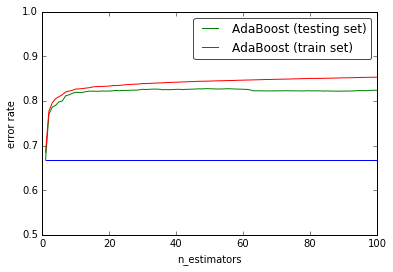

In [72]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot([1, n_estimators], [dt_score,dt_score])

ada_score_eval = np.zeros((n_estimators,))
for i, t_eval_hat in enumerate(ada.staged_predict_proba(X_eval)):
    ada_score_eval[i] = roc_auc_score(t_eval, t_eval_hat[:,1])

ada_score_fit = np.zeros((n_estimators,))
for i, t_fit_hat in enumerate(ada.staged_predict_proba(X_fit)):
    ada_score_fit[i] = roc_auc_score(t_fit, t_fit_hat[:,1])

ax.plot(np.arange(n_estimators) + 1, ada_score_eval, label='AdaBoost (testing set)')
ax.plot(np.arange(n_estimators) + 1, ada_score_fit, label='AdaBoost (train set)')

ax.set_ylim((0.5, 1))
ax.set_xlabel('n_estimators')
ax.set_ylabel('error rate')

leg = ax.legend(loc='upper right', fancybox=True)
leg.get_frame().set_alpha(0.7)

plt.show()


In [73]:
cv_scores={}
cv_scores['Decision tree']=score_model(dt, X_tr,t_tr)
cv_scores['Adaboost']=score_model(ada, X_tr,t_tr)
print cv_scores

{'Adaboost': array([ 0.82045366,  0.83416183,  0.83536657,  0.82177998,  0.82130414,
        0.82643113]), 'Decision tree': array([ 0.68322822,  0.68835284,  0.68050652,  0.67298635,  0.67207695,
        0.68406481])}


In [10]:
ada = AdaBoostClassifier(
            base_estimator=dt,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            algorithm="SAMME.R")
ada.fit(X_fit, t_fit)
clf = AdaBoostClassifier(
      base_estimator=dt,
      algorithm="SAMME.R")
#parameters = {
#    'learning_rate': [0.5,1,1.5,2],
#    'n_estimators': [10, 30, 50,70,100,200]
#}

parameters = {
    'learning_rate': [0.4,0.5,0.6,0.7],
    'n_estimators': [40, 50, 60]
}

clf = grid_search.GridSearchCV(clf, parameters, n_jobs=4, cv=skf_cv, scoring='roc_auc')
clf.fit(X_tr, t_tr)

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 0 0], n_folds=6, shuffle=True, random_state=None),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'n_estimators': [40, 50, 60], 'learning_rate': [0.4, 0.5, 0.6, 0.7]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [11]:
print clf.best_params_
print clf.best_score_
print clf.best_estimator_

{'n_estimators': 60, 'learning_rate': 0.4}
0.833066620088
AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.4, n_estimators=60, random_state=None)
